<a href="https://colab.research.google.com/github/Matig91/Colab-projects/blob/main/CS%20231n%20Convolutional%20NN%20(Stanford)/4_two_layer_net.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# This mounts your Google Drive to the Colab VM.
from google.colab import drive
drive.mount('/content/drive')

# TODO: Enter the foldername in your Drive where you have saved the unzipped
# assignment folder, e.g. 'cs231n/assignments/assignment1/'
FOLDERNAME = 'cs231n/assignments/assignment1/'
assert FOLDERNAME is not None, "[!] Enter the foldername."

# Now that we've mounted your Drive, this ensures that
# the Python interpreter of the Colab VM can load
# python files from within it.
import sys
sys.path.append('/content/drive/My Drive/{}'.format(FOLDERNAME))

# This downloads the CIFAR-10 dataset to your Drive
# if it doesn't already exist.
%cd /content/drive/My\ Drive/$FOLDERNAME/cs231n/datasets/
!bash get_datasets.sh
%cd /content/drive/My\ Drive/$FOLDERNAME

Mounted at /content/drive
/content/drive/My Drive/cs231n/assignments/assignment1/cs231n/datasets
/content/drive/My Drive/cs231n/assignments/assignment1


# Fully-Connected Neural Nets
In this exercise we will implement fully-connected networks using a modular approach. For each layer we will implement a `forward` and a `backward` function. The `forward` function will receive inputs, weights, and other parameters and will return both an output and a `cache` object storing data needed for the backward pass, like this:

```python
def layer_forward(x, w):
  """ Receive inputs x and weights w """
  # Do some computations ...
  z = # ... some intermediate value
  # Do some more computations ...
  out = # the output
   
  cache = (x, w, z, out) # Values we need to compute gradients
   
  return out, cache
```

The backward pass will receive upstream derivatives and the `cache` object, and will return gradients with respect to the inputs and weights, like this:

```python
def layer_backward(dout, cache):
  """  Receive dout (derivative of loss with respect to outputs) and cache,
  and compute derivative with respect to inputs.  """
  # Unpack cache values
  x, w, z, out = cache
  
  # Use values in cache to compute derivatives
  dx = # Derivative of loss with respect to x
  dw = # Derivative of loss with respect to w
  
  return dx, dw
```

After implementing a bunch of layers this way, we will be able to easily combine them to build classifiers with different architectures.
  

In [ ]:
# As usual, a bit of setup
# from __future__ import print_function
import time
import numpy as np
import matplotlib.pyplot as plt
from cs231n.classifiers import fc_net
from cs231n.data_utils import get_CIFAR10_data
from cs231n.gradient_check import eval_numerical_gradient, eval_numerical_gradient_array
from cs231n.solver import Solver

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# for auto-reloading external modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

def rel_error(x, y):
  """ returns relative error """
  return np.max(np.abs(x - y) / (np.maximum(1e-8, np.abs(x) + np.abs(y))))

In [ ]:
# Load the (preprocessed) CIFAR10 data.

data = get_CIFAR10_data()
for k, v in list(data.items()):
  print(('%s: ' % k, v.shape))

('X_train: ', (49000, 3, 32, 32))
('y_train: ', (49000,))
('X_val: ', (1000, 3, 32, 32))
('y_val: ', (1000,))
('X_test: ', (1000, 3, 32, 32))
('y_test: ', (1000,))


In [ ]:
# @title file cs231n/layers.py
import numpy as np

def affine_forward(x, w, b):
    ''' x - numpy array of shape (N, d1, d2, .., dk); N - training examples (batch)
    w - weights of shape D x M;  out.shape = N x M    '''

    x_resh = np.reshape(x, (x.shape[0], -1))

    out = x_resh @ w + b

    cache = (x, w, b)
    return out, cache

def affine_backward(dout, cache):
    # initial dout is usually One - then, it goes as per Chain Rule. Cache is used to make calculation
    # the case presented for Affine layer (Fully-connected layer)
    x, w, b = cache
    dx, dw, db = None, None, None
    # x  = x.reshape(x.shape[0], -1)
    x_reshaped = x.reshape(x.shape[0], -1)
    dx = (dout @ w.T).reshape(x.shape[0], *x.shape[1:])

    dw = x_reshaped.T @ dout   # D x M = D x N | N x M
    # dx = (dout * w.T).reshape(x.shape[0], *x.shape[1:])   # N x D = N x M | M x D
    db = np.sum(dout, axis=0)   # (M, )

    return dx, dw, db

# Affine layer: forward
Open the file `cs231n/layers.py` and implement the `affine_forward` function.

Once you are done you can test your implementaion by running the following:

In [ ]:
# Test the affine_forward function
num_inputs = 2
input_shape = (4, 5, 6)
output_dim = 3

input_size = num_inputs * np.prod(input_shape)
weight_size = output_dim * np.prod(input_shape)

x = np.linspace(-0.1, 0.5, num=input_size).reshape(num_inputs, *input_shape)
w = np.linspace(-0.2, 0.3, num=weight_size).reshape(np.prod(input_shape), output_dim)
b = np.linspace(-0.3, 0.1, num=output_dim)

out, _ = affine_forward(x, w, b)

correct_out = np.array([[ 1.49834967,  1.70660132,  1.91485297],
                        [ 3.25553199,  3.5141327,   3.77273342]])

# Compare your output with ours. The error should be around e-9 or less.
print('Testing affine_forward function:')
print('difference: ', rel_error(out, correct_out))
out, correct_out #, x, w, b

Testing affine_forward function:
difference:  9.769849468192957e-10


(array([[1.49834967, 1.70660132, 1.91485297],
        [3.25553199, 3.5141327 , 3.77273342]]),
 array([[1.49834967, 1.70660132, 1.91485297],
        [3.25553199, 3.5141327 , 3.77273342]]))

# Affine layer: backward
Now implement the `affine_backward` function and test your implementation using numeric gradient checking.

In [ ]:
# Test the affine_backward function
np.random.seed(231)
x = np.random.randn(10, 2, 3)
w = np.random.randn(6, 5)
b = np.random.randn(5)
dout = np.random.randn(10, 5)

dx_num = eval_numerical_gradient_array(lambda x: affine_forward(x, w, b)[0], x, dout)
dw_num = eval_numerical_gradient_array(lambda w: affine_forward(x, w, b)[0], w, dout)
db_num = eval_numerical_gradient_array(lambda b: affine_forward(x, w, b)[0], b, dout)

_, cache = affine_forward(x, w, b)
dx, dw, db = affine_backward(dout, cache)

# The error should be around e-10 or less
print('Testing affine_backward function:')
print('dx error: ', rel_error(dx_num, dx))
print('dw error: ', rel_error(dw_num, dw))
print('db error: ', rel_error(db_num, db))
np.round(dw,1), np.round(db,1)

Testing affine_backward function:
dx error:  5.399100368651805e-11
dw error:  9.904211865398145e-11
db error:  2.4122867568119087e-11


(array([[-2.4, -0.5,  0.3,  2.9,  1.1],
        [-3.5, -2.1, -3.6, -2. , -2.2],
        [ 5.1,  1.5,  3.3,  5.9, -2.2],
        [-0.7, -0.2, -2.3,  2.8, -3.2],
        [ 2.2,  2.3, -4.9,  2.1, -3.3],
        [-0.8, -1.3, -3.1,  0.2, -3.1]]),
 array([-5.8, -2.1, -3.9, -4.1, -0.1]))

# ReLU activation: forward
Implement the forward pass for the ReLU activation function in the `relu_forward` function and test your implementation using the following:

In [ ]:
def relu_forward(x):
    """ Computes the forward pass for a layer of rectified linear units (ReLUs).
    Input: - x: Inputs, of any shape
    Returns a tuple of: - out: Output, of the same shape as x - cache: x  """
    out = None
    out = np.maximum(x, 0)
    cache = x
    return out, cache

def relu_backward(dout, cache):
    """ Computes the backward pass for a layer of rectified linear units (ReLUs).
    Input: - dout: Upstream derivatives, of any shape
    - cache: Input x, of same shape as dout;  Returns: - dx: Gradient with respect to x """
    dx, x = None, cache

    # dx = dout.copy(); dx[x<0] = 0
    dx = np.where(x > 0, dout, 0)
    # dx = dout * (x>0)

    return dx

In [ ]:
# Test the relu_forward function

x = np.linspace(-0.5, 0.5, num=12).reshape(3, 4)

out, _ = relu_forward(x)
correct_out = np.array([[ 0.,          0.,          0.,          0.,        ],
                        [ 0.,          0.,          0.04545455,  0.13636364,],
                        [ 0.22727273,  0.31818182,  0.40909091,  0.5,       ]])

# Compare your output with ours. The error should be on the order of e-8
print('Testing relu_forward function:')
print('difference: ', rel_error(out, correct_out))

Testing relu_forward function:
difference:  4.999999798022158e-08


# ReLU activation: backward
Now implement the backward pass for the ReLU activation function in the `relu_backward` function and test your implementation using numeric gradient checking:

In [ ]:
np.random.seed(231)
x = np.random.randn(10, 10)
dout = np.random.randn(*x.shape)

dx_num = eval_numerical_gradient_array(lambda x:
                                       relu_forward(x)[0], x, dout)
_, cache = relu_forward(x)
dx = relu_backward(dout, cache)

# The error should be on the order of e-12
print('Testing relu_backward function:')
print('dx error: ', rel_error(dx_num, dx))

Testing relu_backward function:
dx error:  3.2756349136310288e-12


## Inline Question 1:

We've only asked you to implement ReLU, but there are a number of different activation functions that one could use in neural networks, each with its pros and cons. In particular, an issue commonly seen with activation functions is getting zero (or close to zero) gradient flow during backpropagation. Which of the following activation functions have this problem? If you consider these functions in the one dimensional case, what types of input would lead to this behaviour?
1. Sigmoid
2. ReLU
3. Leaky ReLU

## Answer:
[FILL THIS IN]


# "Sandwich" layers
There are some common patterns of layers that are frequently used in neural nets. For example, affine layers are frequently followed by a ReLU nonlinearity. To make these common patterns easy, we define several convenience layers in the file `cs231n/layer_utils.py`.

For now take a look at the `affine_relu_forward` and `affine_relu_backward` functions, and run the following to numerically gradient check the backward pass:

In [ ]:
def affine_relu_forward(x, w, b):
    """ Convenience layer that perorms an affine transform followed by a ReLU
    Inputs: - x: Input to the affine layer;   - w, b: Weights for the affine layer
    Returns a tuple of:   - out: Output from the ReLU; - cache: Object to give to the backward pass    """
    # cache = (x, w, b)
    # x_rsh = np.reshape(x, (x.shape[0], -1))
    # out   = np.maximum((0, x @ w + b), axis=1, keepdim=True)
    a, fc_cache = affine_forward(x, w, b)
    out, relu_cache = relu_forward(a)
    cache = (fc_cache, relu_cache)
    return out, cache

def affine_relu_backward(dout, cache):
    """  Backward pass for the affine-relu convenience layer """
    fc_cache, relu_cache = cache

    da = relu_backward(dout, relu_cache)

    dx, dw, db  = affine_backward(da, fc_cache)

    return dx, dw, db

In [ ]:
np.random.seed(231)
x = np.random.randn(2, 3, 4)
w = np.random.randn(12, 10)
b = np.random.randn(10)
dout = np.random.randn(2, 10)

out, cache = affine_relu_forward(x, w, b)
dx, dw, db = affine_relu_backward(dout, cache)

dx_num = eval_numerical_gradient_array(lambda x: affine_relu_forward(x, w, b)[0], x, dout)
dw_num = eval_numerical_gradient_array(lambda w: affine_relu_forward(x, w, b)[0], w, dout)
db_num = eval_numerical_gradient_array(lambda b: affine_relu_forward(x, w, b)[0], b, dout)

# Relative error should be around e-10 or less
print('Testing affine_relu_forward and affine_relu_backward:')
print('dx error: ', rel_error(dx_num, dx))
print('dw error: ', rel_error(dw_num, dw))
print('db error: ', rel_error(db_num, db))

Testing affine_relu_forward and affine_relu_backward:
dx error:  2.299579177309368e-11
dw error:  8.162011105764925e-11
db error:  7.826724021458994e-12


# Loss layers: Softmax and SVM
Now implement the loss and gradient for softmax and SVM in the `softmax_loss` and `svm_loss` function in `cs231n/layers.py`. These should be similar to what you implemented in `cs231n/classifiers/softmax.py` and `cs231n/classifiers/linear_svm.py`.

You can make sure that the implementations are correct by running the following:

In [ ]:
# @title cs231n/layers . py
def svm_loss(x, y):
    """  Computes the loss and gradient using for multiclass SVM classification.
    Inputs:  - x: Input data, of shape (N, C) where x[i, j] is the score for the jth
      class for the ith input.
    - y: Vector of labels, of shape (N,) where y[i] is the label for x[i] and
      0 <= y[i] < C
    Returns a tuple of:    - loss: Scalar giving the loss
    - dx: Gradient of the loss with respect to x """
    loss, dx = None, None

    # scores      = X @ W
    N = len(y)                                       # number of samples
    x_true = x[np.arange(N), y].reshape(N,1)         # scores for true labels
    margins     = np.maximum(0, x - x_true + 1)   # margin for each score
    margins[range(N), y] = 0                      # or: loss = margins.sum() / N - 1
    loss        = np.sum(margins)/N
    dx = (margins>0).astype(int) / N
    dx[range(N), y] = -dx.sum(axis=1)
    return loss, dx

def softmax_loss(x, y):
  """  Computes the loss and gradient for softmax classification.
    Inputs:    - x: Input data, of shape (N, C) where x[i, j] is the score for the jth
      class for the ith input.  - y: Vector of labels, of shape (N,) where y[i] is the label for x[i] and 0 <= y[i] < C
    Returns a tuple of: - loss: Scalar giving the loss; - dx: Gradient of the loss with respect to x    """
  loss, dx = None, None
  N = len(y)                          # number of samples
  softmax  = np.exp(x - np.max(x, keepdims=True))     # numerically stable exponents | Softmax = P
  softmax /= np.sum(softmax, axis=1, keepdims=True)
  loss     = -np.log(softmax[np.arange(N), y]).sum() / N

  softmax[np.arange(N), y] -= 1
  dx =  softmax / N

  return loss, dx

In [ ]:
np.random.seed(231)
num_classes, num_inputs = 10, 50
x = 0.001 * np.random.randn(num_inputs, num_classes)
y = np.random.randint(num_classes, size=num_inputs)

dx_num = eval_numerical_gradient(lambda x: svm_loss(x, y)[0], x, verbose=False)
loss, dx = svm_loss(x, y)

# Test svm_loss function. Loss should be around 9 and dx error should be around the order of e-9
print('Testing svm_loss:')
print('loss: ', loss)
print('dx error: ', rel_error(dx_num, dx))

dx_num = eval_numerical_gradient(lambda x: softmax_loss(x, y)[0], x, verbose=False)
loss, dx = softmax_loss(x, y)

# Test softmax_loss function. Loss should be close to 2.3 and dx error should be around e-8
print('\nTesting softmax_loss:')
print('loss: ', loss)
print('dx error: ', rel_error(dx_num, dx))

Testing svm_loss:
loss:  8.999602749096233
dx error:  1.4021566006651672e-09

Testing softmax_loss:
loss:  2.3025458445007376
dx error:  8.234144091578429e-09


# Two-layer network
Open the file `cs231n/classifiers/fc_net.py` and complete the implementation of the `TwoLayerNet` class. Read through it to make sure you understand the API. You can run the cell below to test your implementation.

In [ ]:
# @title TwoLayerNet (cs231n/classifiers/fc_net.py)

from __future__ import print_function
import numpy as np
import matplotlib.pyplot as plt

class TwoLayerNet(object):
  """ A two-layer fully-connected neural network. The net has an input dimension of
  N, a hidden layer dimension of H, and performs classification over C classes.
  We train the network with a softmax loss function and L2 regularization on the
  weight matrices. The network uses a ReLU nonlinearity after the first fully
  connected layer. In other words, the network has the following architecture:
  input - fully connected layer - ReLU - fully connected layer - softmax
  The outputs of the second fully-connected layer are the scores for each class.  """

  def __init__(self, input_size, hidden_size, output_size, std=1e-3, reg=0.0):
    """ Initialize the model. Weights are initialized to small random values and biases are initialized to zero. Weights and biases are stored in the
    variable self.params, which is a dictionary with the following keys:  W1: First layer weights, shape (D, H);
    b1: First layer biases, shape (H,)  W2: Second layer weights, shape (H, C); b2: Second layer biases, shape (C,)
    Inputs: - input_size: The dimension D of the input data. - hidden_size: The number of neurons H in the hidden layer. - output_size: The number of classes C  """

    self.params = {}
    self.params['W1'] = std * np.random.randn(input_size, hidden_size)
    self.params['b1'] = np.zeros(hidden_size)
    self.params['W2'] = std * np.random.randn(hidden_size, output_size)
    self.params['b2'] = np.zeros(output_size)
    self.reg = reg


  def loss(self, X, y=None):
    """ Compute the loss and gradients for a two layer fully connected neural network.
    Inputs:    - X: Input data of shape (N, D). Each X[i] is a training sample.
    - y: Vector of training labels. y[i] is the label for X[i], and each y[i] is
      an integer in the range 0 <= y[i] < C. This parameter is optional; if it
      is not passed then we only return scores, and if it is passed then we
      instead return the loss and gradients.  - reg: Regularization strength.
    Returns:  If y is None, return a matrix scores of shape (N, C) where scores[i, c] is
    the score for class c on input X[i].  If y is not None, instead return a tuple of:
    - loss: Loss (data loss and regularization loss) for this batch of training samples.
    - grads: Dictionary mapping parameter names to gradients of those parameters
      with respect to the loss function; has the same keys as self.params.    """
    # Unpack variables from the params dictionary
    W1, b1 = self.params['W1'], self.params['b1']
    W2, b2 = self.params['W2'], self.params['b2']

    N = X.shape[0]
    X = X.reshape(N, -1)
    # Compute the forward pass
    scores = None
    # TODO: Perform the forward pass, computing the class scores for the input. # Store the result in the scores variable, which should be an array of shape (N, C).

    fc1 = X.dot(W1) + b1     # 1st laye: N x D @ D x H = N x H
    X2  = np.maximum(0, fc1) # ReLU
    scores = fc1.dot(W2) + b2 # 2nd layer: N x H @ H x C = N x C = y.shape

    if y is None:     # If the targets are not given then jump out, we're done
      return scores

    # Backward pass: compute gradients
    loss, grads = 0, {}

    scores = scores - np.max(scores, axis=1, keepdims=True) # avoid numeric instability

    softmax = np.exp(scores)/np.sum(np.exp(scores), axis=1, keepdims=True)
    loss = -np.sum( np.log(softmax[np.arange(N), y]) ) / N

    loss += 0.5*self.reg * ( np.sum(W1*W1)+np.sum(W2*W2) ) # regularization

    '''TODO: Compute the backward pass, computing the derivatives of the weights
    and biases. Store the results in the grads dictionary. For example,
    grads['W1'] should store the gradient on W1, and be a matrix of same size '''
    softmax[ np.arange(N), y ] -= 1  # d_softmax from here - down below
    softmax_d = softmax/N  # Softmax backpropogation matrix (link to ReLU output)

    # W2 gradient
    dW2 = X2.T.dot(softmax_d)      # H x N @ N x C = H x C
    db2 = softmax_d.sum(axis=0)    # (, C)

    # W1 gradient
    dX2 = softmax_d.dot(W2.T)     # criss-cross with dW2 (see above) || N x C | C x H  = N x H
    dfc1 = dX2 * (fc1>0)                # Relu chain completed (toward ultimate params of W1)

    dW1  = X.T.dot(dfc1)   # D x H = D x N | N x H = X.T | dfc1 - chain rule: legacy of grads
    db1 =  dfc1.sum(axis=0)
    # ..if you need to pass the grads deeper: dX = dfc1.dot(W1.T)

    # regularization gradient
    dW2 += W2 * self.reg; dW1 += W1 * self.reg
    grads = {'W1':dW1, 'b1':db1, 'W2':dW2, 'b2':db2}
    return loss, grads

  def train(self, X, y, X_val, y_val, learning_rate=1e-3, learning_rate_decay=1.0,
            num_iters=100, batch_size=200, verbose=False):

    """    Train this neural network using stochastic gradient descent.
    Inputs: - X: A numpy array of shape (N, D) giving training data.
    - y: A numpy array f shape (N,) giving training labels; y[i] = c means that
      X[i] has label c, where 0 <= c < C.
    - X_val: A numpy array of shape (N_val, D) giving validation data.
    - y_val: A numpy array of shape (N_val,) giving validation labels.
    - learning_rate: Scalar giving learning rate for optimization.
    - learning_rate_decay: Scalar giving factor used to decay the learning rate after each epoch.
    - reg: Scalar giving regularization strength.
    - num_iters: Number of steps to take when optimizing.
    - batch_size: Number of training examples to use per step.
    - verbose: boolean; if true print progress during optimization. """

    num_train = X.shape[0]
    iterations_per_epoch = max(num_train / batch_size, 1)

    # Use SGD to optimize the parameters in self.model
    loss_history = []
    train_acc_history = []
    val_acc_history = []
    for it in range(num_iters):
      X_batch = None
      y_batch = None

      # TODO: Create a random minibatch of training data and labels, storing them in X_batch and y_batch respectively.                             #
      idx = np.random.choice(batch_size, num_train)
      X_batch = X[idx] # broadcasting non-consequitive idxs
      y_batch = y[idx]

      # Compute loss and gradients using the current minibatch
      loss, grads = self.loss(X_batch, y=y_batch)
      loss_history.append(loss)

      # TODO: Use the gradients in the grads dictionary
      # to update parameters of the network (stored in the dictionary self.params)
      # using stochastic gradient descent. You'll need to use the gradients stored in the grads dictionary defined above.
      for key in self.params:
        self.params[key] -= learning_rate*grads[key]

      if verbose and it % 100==0:
        loss_history.append(loss)

      if it % iterations_per_epoch==0:
        learning_rate *= learning_rate_decay
        # Check accuracy
        np.mean(y_batch == self.predict(X_batch))

      for key in self.params:
        self.params[key] -= learning_rate * grads[key]

      if verbose and it % 100 == 0:
        print('iteration %d / %d: loss %f' % (it, num_iters, loss))

      # Every epoch, check train and val accuracy and decay learning rate.
      if it % iterations_per_epoch == 0:
        # Check accuracy
        train_acc = (self.predict(X_batch) == y_batch).mean()
        val_acc = (self.predict(X_val) == y_val).mean()
        train_acc_history.append(train_acc)
        val_acc_history.append(val_acc)
        # Decay learning rate
        learning_rate *= learning_rate_decay

    return {
      'loss_history': loss_history,
      'train_acc_history': train_acc_history,
      'val_acc_history': val_acc_history,
    }

  def predict(self, X): # X text
    """   Use the trained weights of this two-layer network to predict labels for
    data points. For each data point we predict scores for each of the C
    classes, and assign each data point to the class with the highest score.
    Inputs:  - X: A numpy array of shape (N, D) giving N D-dimensional data points to
      classify.  Returns: - y_pred: A numpy array of shape (N,) giving predicted labels for each of
      the elements of X. For all i, y_pred[i] = c means that X[i] is predicted to have class c, where 0 <= c < C.  """
    y_pred = None
    y_pred = np.argmax( self.loss(X), axis=1) # TODO:
    return y_pred

# Solver
Open the file `cs231n/solver.py` and read through it to familiarize yourself with the API. After doing so, use a `Solver` instance to train a `TwoLayerNet` that achieves about `36%` accuracy on the validation set.

In [ ]:
np.random.seed(231)
N, D, H, C = 3, 5, 50, 7
X = np.random.randn(N, D)
y = np.random.randint(C, size=N)

std = 1e-3

model = TwoLayerNet(input_size=D, hidden_size=H, output_size=C, std=std, reg=0.0)
print('Testing initialization ... ')
W1_std = abs(model.params['W1'].std() - std)
b1 = model.params['b1']
W2_std = abs(model.params['W2'].std() - std)
b2 = model.params['b2']

assert W1_std < std / 10, 'First layer weights do not seem right'
assert np.all(b1 == 0), 'First layer biases do not seem right'
assert W2_std < std / 10, 'Second layer weights do not seem right'
assert np.all(b2 == 0), 'Second layer biases do not seem right'

print('Testing test-time forward pass ... ')
model.params['W1'] = np.linspace(-0.7, 0.3, num=D*H).reshape(D, H)
model.params['b1'] = np.linspace(-0.1, 0.9, num=H)
model.params['W2'] = np.linspace(-0.3, 0.4, num=H*C).reshape(H, C)
model.params['b2'] = np.linspace(-0.9, 0.1, num=C)
X = np.linspace(-5.5, 4.5, num=N*D).reshape(D, N).T
scores = model.loss(X)

correct_scores = np.asarray(
  [[11.53165108,  12.2917344,   13.05181771,  13.81190102,  14.57198434, 15.33206765,  16.09215096],
   [12.05769098,  12.74614105,  13.43459113,  14.1230412,   14.81149128, 15.49994135,  16.18839143],
   [12.58373087,  13.20054771,  13.81736455,  14.43418138,  15.05099822, 15.66781506,  16.2846319 ]])
scores_diff = np.abs(scores - correct_scores).sum()
assert scores_diff < 1e-6, 'Problem with test-time forward pass'

print('Testing training loss (no regularization)')
y = np.asarray([0, 5, 1])
loss, grads = model.loss(X, y)
correct_loss = 3.4702243556

assert abs(loss - correct_loss) < 1e-10, 'Problem with training-time loss'

model.reg = 1.0
loss, grads = model.loss(X, y)
correct_loss = 26.5948426952
print(loss)
assert abs(loss - correct_loss) < 1e-10, 'Problem with regularization loss'

# Errors should be around e-7 or less
for reg in [0.0, 0.7]:
  print('Running numeric gradient check with reg = ', reg)
  model.reg = reg
  loss, grads = model.loss(X, y)

  for name in sorted(grads):
    f = lambda _: model.loss(X, y)[0]
    grad_num = eval_numerical_gradient(f, model.params[name], verbose=False)
    print('%s relative error: %.2e' % (name, rel_error(grad_num, grads[name])))

Testing initialization ... 
Testing test-time forward pass ... 
Testing training loss (no regularization)
26.594842695238583
Running numeric gradient check with reg =  0.0
W1 relative error: 1.83e-08
W2 relative error: 3.20e-10
b1 relative error: 9.83e-09
b2 relative error: 4.33e-10
Running numeric gradient check with reg =  0.7
W1 relative error: 2.53e-07
W2 relative error: 2.85e-08
b1 relative error: 1.56e-08
b2 relative error: 9.09e-10


In [ ]:
# @title OPTIMIZERS (EXPERIMENTS)
import numpy as np
class optim:

  def sgd(w, dw, config=None):
      """  Performs vanilla stochastic gradient descent.
      config format:
      - learning_rate: Scalar learning rate. """
      if config is None:
          config = {}
      config.setdefault("learning_rate", 1e-0)

      w -= config["learning_rate"] * dw
      return w, config

  def sgd_momentum(w, dw, config=None):
      """  Performs SGD with momentum. config format:  - Learning_rate: Scalar lr; - Momentum: Scalar between 0 and 1 giving the momentum value. Setting momentum = 0 reduces to sgd.
      - Velocity: A numpy array of the same shape as w and dw used to store a moving average of the gradients. """
      if config is None:
          config = {}
      config.setdefault("learning_rate", 1e-2)
      config.setdefault("momentum", 0.9)                  # 0.5, 0.9, or 0.99
      v = config.get("velocity", np.zeros_like(w))

      next_w = None
      # TODO: Momentum update formula. Store the updated value in next_w variable. You should also use and update the velocity V
      # Momentum update
      v = config['momentum'] * v - config['learning_rate'] * dw     # integrate Velocity
      next_w = w + v                                # integrate Position
      config["velocity"] = v
      return next_w, config

  def rmsprop(w, dw, config=None):
      """  Uses the RMSProp update rule, which uses a moving average of squared
      gradient values to set adaptive per-parameter learning rates.  config format:
      - learning_rate: Scalar learning rate. - decay_rate: Scalar between 0 and 1 giving the decay rate for the squared gradient cache.
      - epsilon: Small scalar used for smoothing to avoid dividing by zero. - cache: Moving average of second moments of gradients."""
      if config is None:
          config = {}
      config.setdefault("learning_rate", 1e-2)
      config.setdefault("decay_rate", 0.99)
      config.setdefault("epsilon", 1e-8)
      config.setdefault("cache", np.zeros_like(w))

      next_w = None
      # TODO: Implement the RMSprop update formula, storing the next value of w #
      # in the next_w variable. Don't forget to update cache value stored in    #
      # config['cache']

      pass

      return next_w, config

In [ ]:
# @title Solver (class)
from __future__ import print_function, division
from future import standard_library

standard_library.install_aliases()
from builtins import range
from builtins import object
import os
import pickle as pickle
import numpy as np
# from cs231n import optim

class Solver(object):

    def __init__(self, model, data, **kwargs):
        self.model = model
        self.X_train = data["X_train"]
        self.y_train = data["y_train"]
        self.X_val = data["X_val"]
        self.y_val = data["y_val"]

        # Unpack keyword arguments
        self.update_rule = kwargs.pop("update_rule", "sgd")
        self.optim_config = kwargs.pop("optim_config", {})
        self.lr_decay = kwargs.pop("lr_decay", 0.95)
        self.batch_size = kwargs.pop("batch_size", 100)
        self.num_epochs = kwargs.pop("num_epochs", 10)
        self.num_train_samples = kwargs.pop("num_train_samples", 1000)
        self.num_val_samples = kwargs.pop("num_val_samples", None)

        self.checkpoint_name = kwargs.pop("checkpoint_name", None)
        self.print_every = kwargs.pop("print_every", 100)
        self.verbose = kwargs.pop("verbose", True)

        # Throw an error if there are extra keyword arguments
        if len(kwargs) > 0:
            extra = ", ".join('"%s"' % k for k in list(kwargs.keys()))
            raise ValueError("Unrecognized arguments %s" % extra)

        # Make sure the update rule exists, then replace the string
        # # name with the actual function
        # if not hasattr(optim, self.update_rule):
        #     raise ValueError('Invalid update_rule "%s"' % self.update_rule)
        self.update_rule = getattr(optim, self.update_rule)

        self._reset()

    def _reset(self):
        """   Set up some book-keeping variables for optimization. Don't call this
        manually.   """
        # Set up some variables for book-keeping
        self.epoch = 0
        self.best_val_acc = 0
        self.best_params = {}
        self.loss_history = []
        self.train_acc_history = []
        self.val_acc_history = []

        # Make a deep copy of the optim_config for each parameter
        self.optim_configs = {}
        for p in self.model.params:
            d = {k: v for k, v in self.optim_config.items()}
            self.optim_configs[p] = d

    def _step(self):
      """  Make a single gradient update. This is called by train() and should not
        be called manually.   """
      # Make a minibatch of training data
      num_train = self.X_train.shape[0]
      batch_mask = np.random.choice(num_train, self.batch_size)
      X_batch = self.X_train[batch_mask]
      y_batch = self.y_train[batch_mask]

      # Compute loss and gradient
      loss, grads = self.model.loss(X_batch, y_batch)
      self.loss_history.append(loss)

      # Perform a parameter update
      for p, w in self.model.params.items():
          dw = grads[p]
          config = self.optim_configs[p]
          next_w, next_config   = self.update_rule(w, dw, config)
          self.model.params[p]  = next_w
          self.optim_configs[p] = next_config

    def _save_checkpoint(self):
        if self.checkpoint_name is None:
            return
        checkpoint = {
            "model": self.model,
            "update_rule": self.update_rule,
            "lr_decay": self.lr_decay,
            "optim_config": self.optim_config,
            "batch_size": self.batch_size,
            "num_train_samples": self.num_train_samples,
            "num_val_samples": self.num_val_samples,
            "epoch": self.epoch,
            "loss_history": self.loss_history,
            "train_acc_history": self.train_acc_history,
            "val_acc_history": self.val_acc_history,
        }
        filename = "%s_epoch_%d.pkl" % (self.checkpoint_name, self.epoch)
        if self.verbose:
            print('Saving checkpoint to "%s"' % filename)
        with open(filename, "wb") as f:
            pickle.dump(checkpoint, f)

    def check_accuracy(self, X, y, num_samples=None, batch_size=100):
        """  Check accuracy of the model on the provided data.
        Inputs:        - X: Array of data, of shape (N, d_1, ..., d_k)
        - y: Array of labels, of shape (N,) - num_samples: If not None, subsample the data and only test the model
          on num_samples datapoints.
        - batch_size: Split X and y into batches of this size to avoid using
          too much memory.        Returns:  - acc: Scalar giving the fraction of instances that were correctly
          classified by the model.  """

        # Maybe subsample the data
        N = X.shape[0]
        if num_samples is not None and N > num_samples:
            mask = np.random.choice(N, num_samples)
            N = num_samples
            X = X[mask]
            y = y[mask]

        # Compute predictions in batches
        num_batches = N // batch_size
        if N % batch_size != 0:
            num_batches += 1
        y_pred = []
        for i in range(num_batches):
            start = i * batch_size
            end = (i + 1) * batch_size
            scores = self.model.loss(X[start:end])
            y_pred.append(np.argmax(scores, axis=1))
        y_pred = np.hstack(y_pred)
        acc = np.mean(y_pred == y)

        return acc

    def train(self):
        """ Run optimization to train the model."""
        num_train = self.X_train.shape[0]
        iterations_per_epoch = max(num_train // self.batch_size, 1)
        num_iterations = self.num_epochs * iterations_per_epoch

        for t in range(num_iterations):
            self._step()

            # Maybe print training loss
            if self.verbose and t % self.print_every == 0:
                print(
                    "(Iteration %d / %d) loss: %f"
                    % (t + 1, num_iterations, self.loss_history[-1])
                )

            # At the end of every epoch, increment the epoch counter and decay
            # the learning rate.
            epoch_end = (t + 1) % iterations_per_epoch == 0
            if epoch_end:
                self.epoch += 1
                for k in self.optim_configs:
                    self.optim_configs[k]["learning_rate"] *= self.lr_decay

            # Check train and val accuracy on the first iteration, the last
            # iteration, and at the end of each epoch.
            first_it = t == 0
            last_it = t == num_iterations - 1
            if first_it or last_it or epoch_end:
                train_acc = self.check_accuracy(
                    self.X_train, self.y_train, num_samples=self.num_train_samples
                )
                val_acc = self.check_accuracy(
                    self.X_val, self.y_val, num_samples=self.num_val_samples
                )
                self.train_acc_history.append(train_acc)
                self.val_acc_history.append(val_acc)
                self._save_checkpoint()

                if self.verbose:
                    print(
                        "(Epoch %d / %d) train acc: %f; val_acc: %f; %f; %f"
                        % (self.epoch, self.num_epochs, train_acc, val_acc, self.loss_history[-1], self.optim_config['learning_rate'])
                    )
                # Keep track of the best model
                if val_acc > self.best_val_acc:
                    self.best_val_acc = val_acc
                    self.best_params = {}
                    for k, v in self.model.params.items():
                        self.best_params[k] = v.copy()

        # At the end of training swap the best params into the model
        self.model.params = self.best_params

In [ ]:
# @title Run the Model ( | solver --> TwoLayerNet | )
from datetime import datetime
print(datetime.now())

input_size = 32 * 32 * 3
hidden_size = 50
num_classes = 10
model = TwoLayerNet(input_size, hidden_size, num_classes, reg=0.0000001)
solver = None

solver = Solver(model, data, optim_config = {'learning_rate': 3e-6},
                lr_decay=0.9, print_every=5000,
                num_epochs=25, verbose=True)
solver.train()
plt.plot(solver.loss_history, 'o')
print(solver.loss_history[-1], solver.train_acc_history[-1], solver.val_acc_history[-1])

2025-02-13 11:03:57.416241
(Iteration 1 / 12250) loss: 2.305861
(Epoch 0 / 25) train acc: 0.075000; val_acc: 0.080000; 2.305861; 0.000003
(Epoch 1 / 25) train acc: 0.131000; val_acc: 0.128000; 2.303269; 0.000003
(Epoch 2 / 25) train acc: 0.174000; val_acc: 0.187000; 2.295728; 0.000003
(Epoch 3 / 25) train acc: 0.210000; val_acc: 0.224000; 2.289495; 0.000003
(Epoch 4 / 25) train acc: 0.236000; val_acc: 0.240000; 2.289999; 0.000003
(Epoch 5 / 25) train acc: 0.217000; val_acc: 0.247000; 2.294890; 0.000003


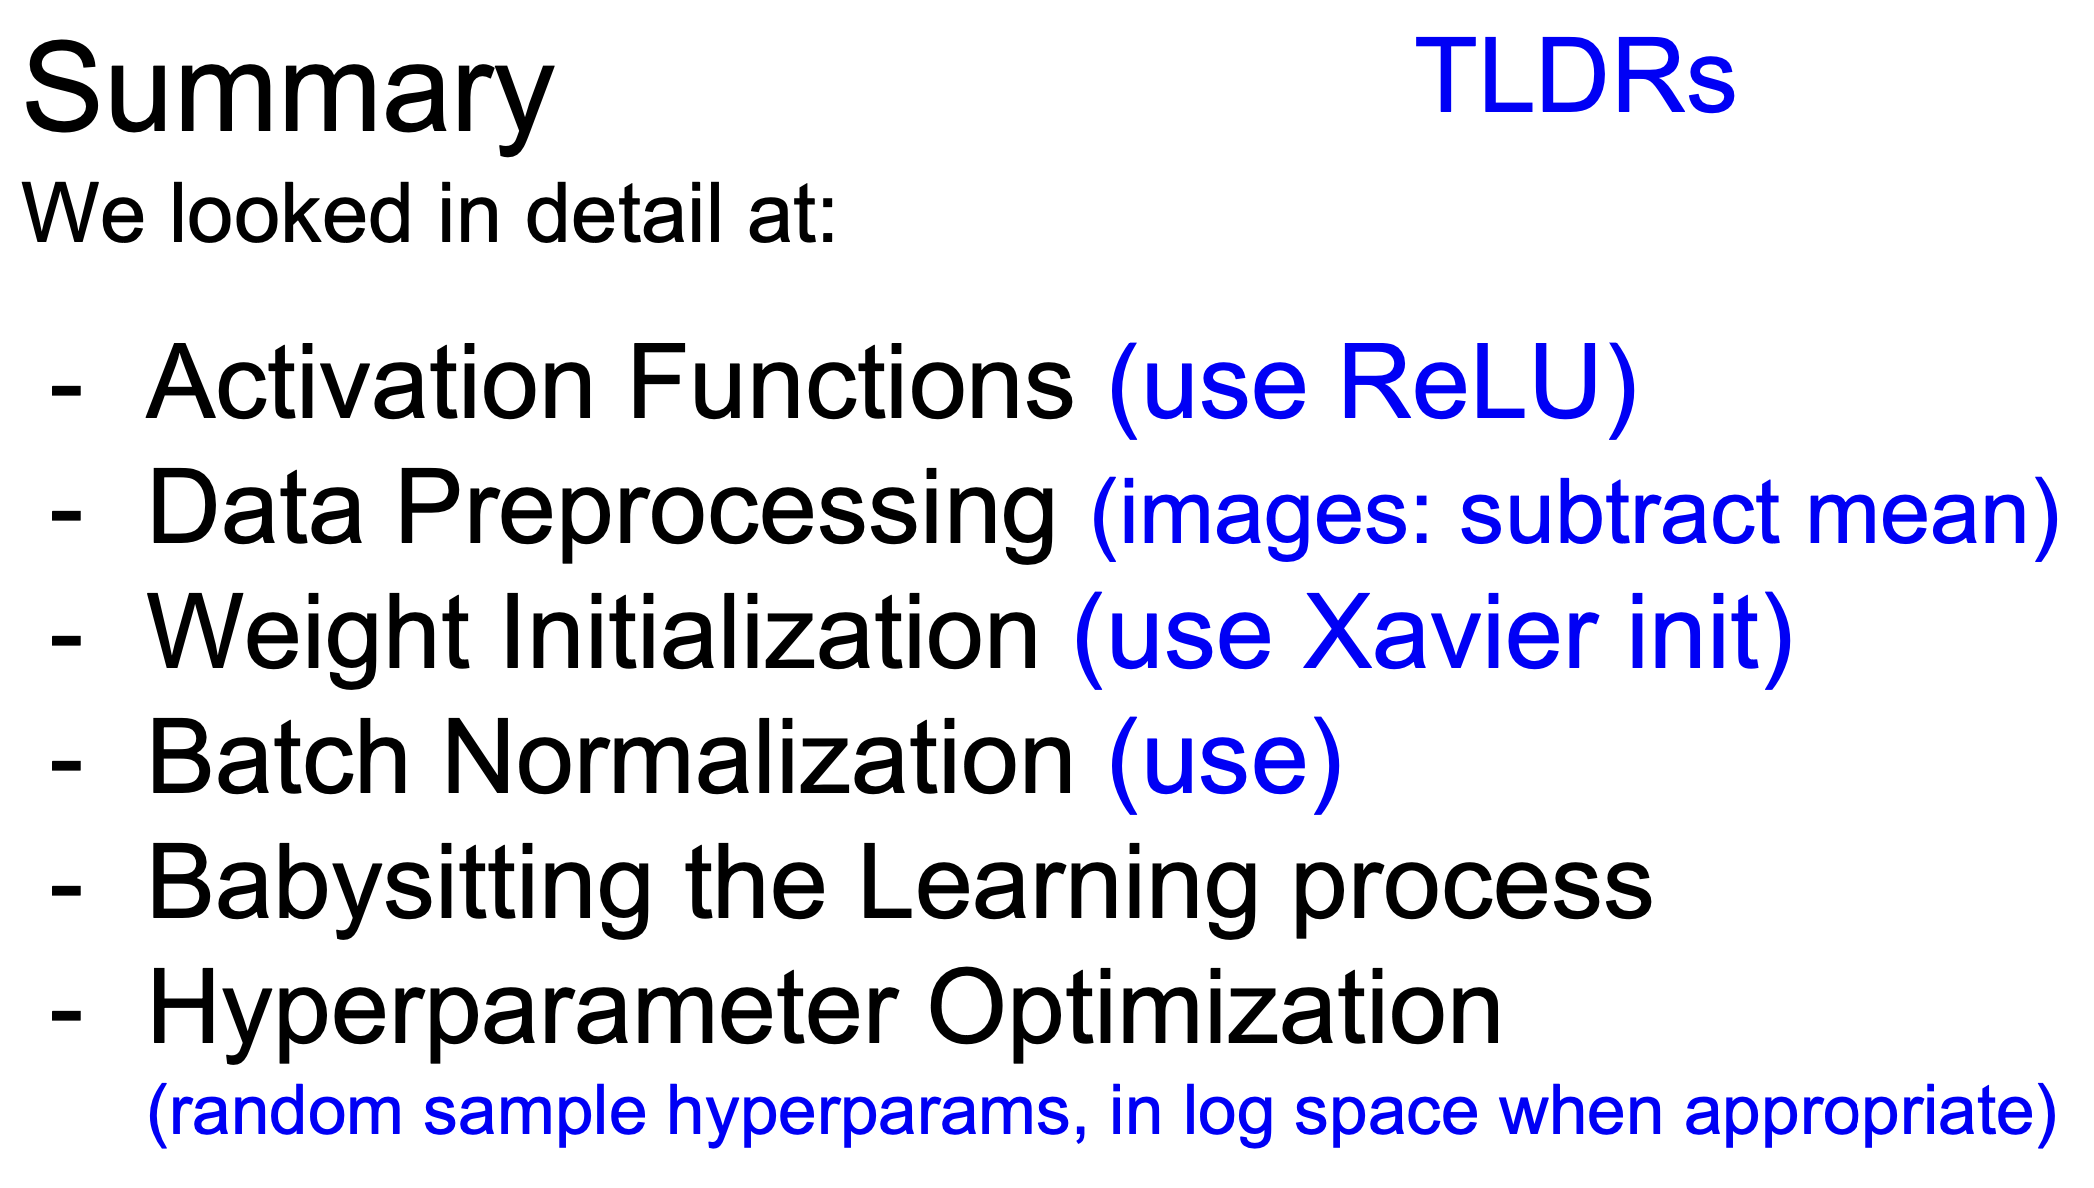

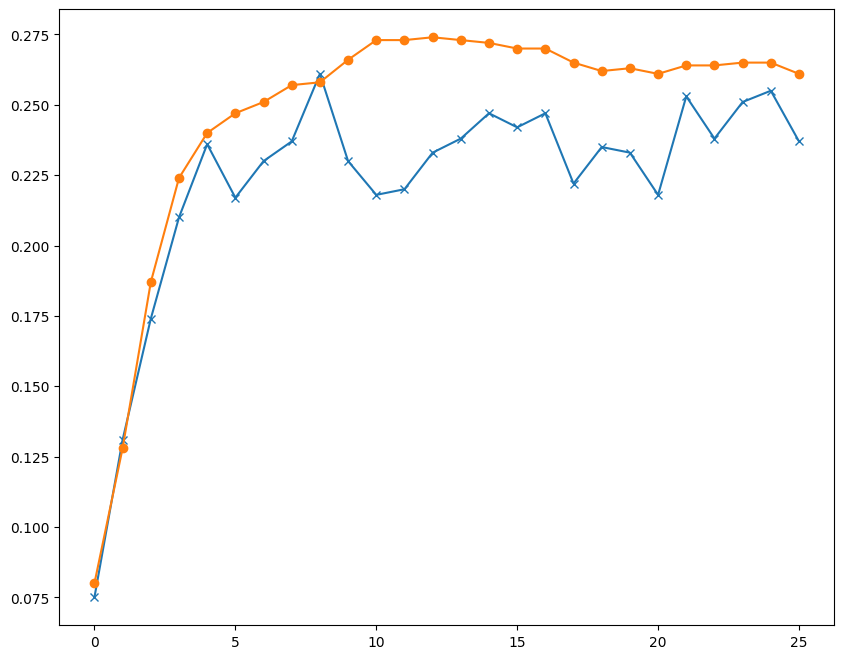

In [ ]:
plt.plot(solver.train_acc_history, '-x', label='train')
plt.plot(solver.val_acc_history, '-o', label='val')

In [ ]:
data_sub = {}
for k, v in list(data.items()):
  data_sub[k] = v[:120]

0.001052500670607106 1.0 0.21666666666666667


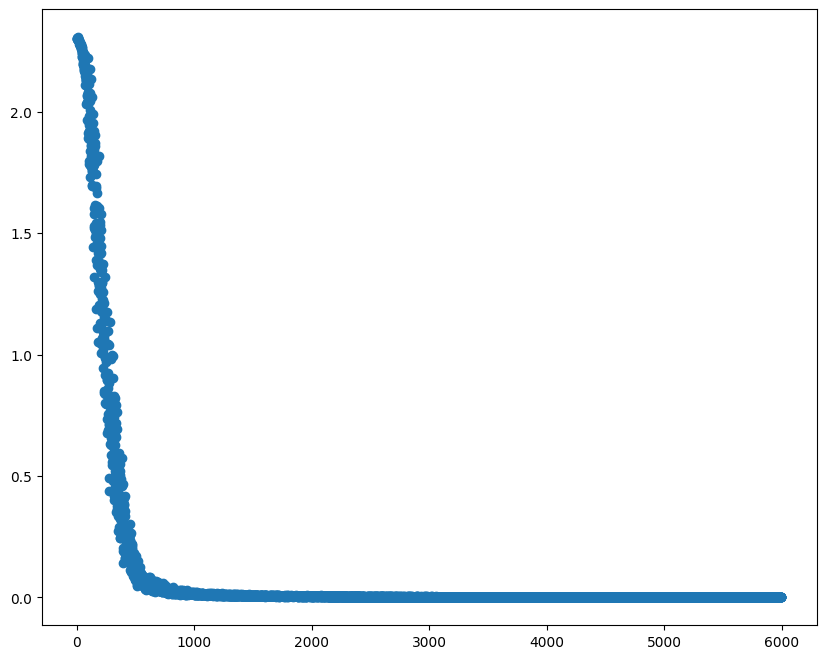

In [ ]:
# @title Make sure that you can overfit very small portion of the training data
input_size = 32 * 32 * 3
hidden_size = 50
num_classes = 10
model = TwoLayerNet(input_size, hidden_size, num_classes, reg=0.000001)
solver = None

solver = Solver(model, data_sub, optim_config = {'learning_rate': 2e-5},
                update_rule = 'sgd_momentum', lr_decay=1.0, print_every=300, batch_size=30,
                num_epochs=1500, verbose=False)

solver.train()

plt.plot(solver.loss_history, 'o')
print(solver.loss_history[-1], solver.train_acc_history[-1], solver.val_acc_history[-1])

In [ ]:
LH = solver.loss_history

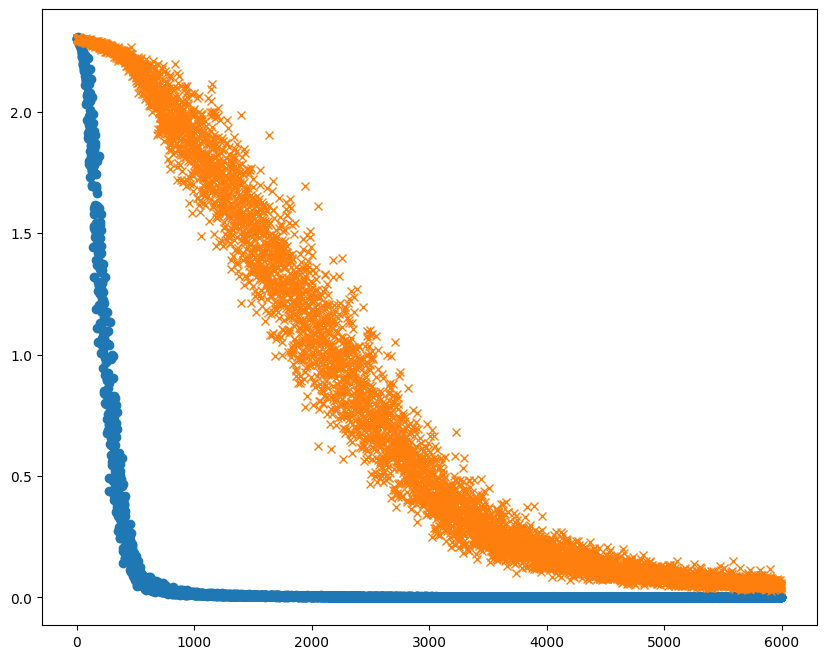

In [ ]:
plt.plot(solver.loss_history, 'o')
plt.plot(LH, 'x')

In [ ]:
"""(2.303367462037363, 0.08, 0.06)
(0.520551074072979, 0.88, 0.1)"""
print((solver.loss_history[1], solver.train_acc_history[1], solver.val_acc_history[1]))
solver.loss_history[-1], solver.train_acc_history[-1], solver.val_acc_history[-1], " / ", max(solver.val_acc_history)

(2.3085884191300408, 0.04, 0.14)


(0.019448309113026082, 1.0, 0.2, ' / ', 0.24)

In [ ]:
max(solver.val_acc_history)

0.24

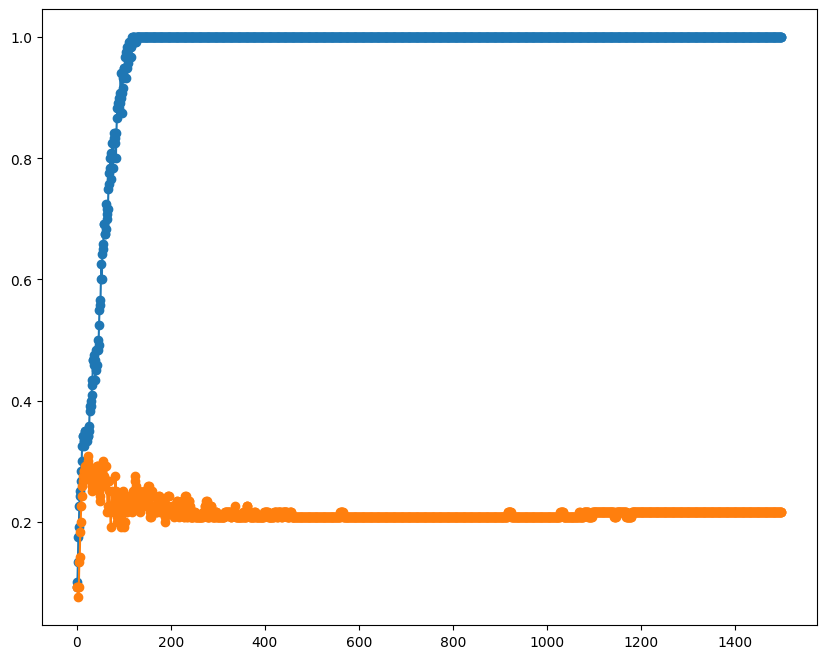

In [ ]:
plt.plot(solver.train_acc_history, '-o', label='train')
plt.plot(solver.val_acc_history, '-o', label='val')
# a = solver.best_params

# Debug the training
With the default parameters we provided above, you should get a validation accuracy of about 0.36 on the validation set. This isn't very good.

One strategy for getting insight into what's wrong is to plot the loss function and the accuracies on the training and validation sets during optimization.

Another strategy is to visualize the weights that were learned in the first layer of the network. In most neural networks trained on visual data, the first layer weights typically show some visible structure when visualized.

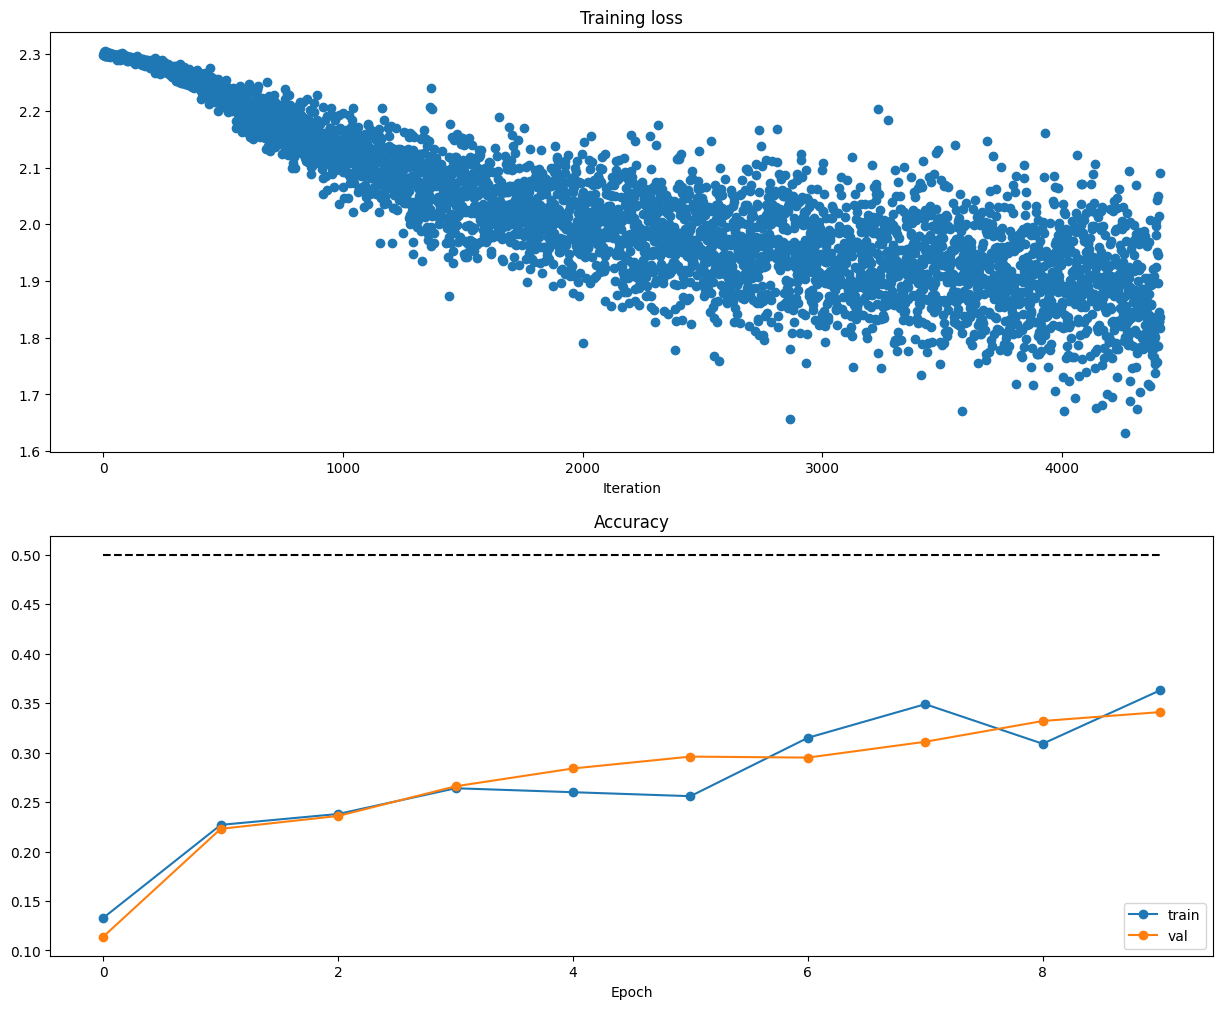

In [ ]:
# Run this cell to visualize training loss and train / val accuracy
plt.subplot(2, 1, 1)
plt.title('Training loss')
plt.plot(solver.loss_history, 'o')
plt.xlabel('Iteration')

plt.subplot(2, 1, 2)
plt.title('Accuracy')
plt.plot(solver.train_acc_history, '-o', label='train')
plt.plot(solver.val_acc_history, '-o', label='val')
plt.plot([0.5] * len(solver.val_acc_history), 'k--')
plt.xlabel('Epoch')
plt.legend(loc='lower right')
plt.gcf().set_size_inches(15, 12)
plt.show()

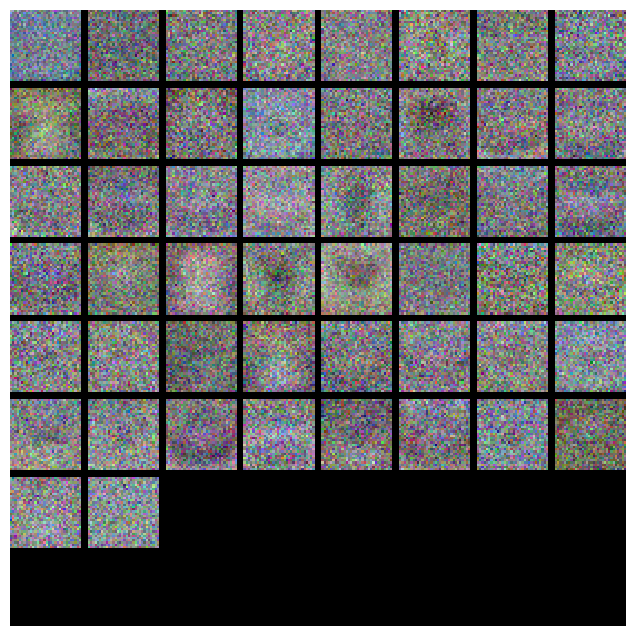

In [ ]:
from cs231n.vis_utils import visualize_grid

# Visualize the weights of the network

def show_net_weights(net):
    W1 = net.params['W1']
    W1 = W1.reshape(3, 32, 32, -1).transpose(3, 1, 2, 0)
    plt.imshow(visualize_grid(W1, padding=3).astype('uint8'))
    plt.gca().axis('off')
    plt.show()

show_net_weights(model)

# Tune your hyperparameters

**What's wrong?**. Looking at the visualizations above, we see that the loss is decreasing more or less linearly, which seems to suggest that the learning rate may be too low. Moreover, there is no gap between the training and validation accuracy, suggesting that the model we used has low capacity, and that we should increase its size. On the other hand, with a very large model we would expect to see more overfitting, which would manifest itself as a very large gap between the training and validation accuracy.

**Tuning**. Tuning the hyperparameters and developing intuition for how they affect the final performance is a large part of using Neural Networks, so we want you to get a lot of practice. Below, you should experiment with different values of the various hyperparameters, including hidden layer size, learning rate, numer of training epochs, and regularization strength. You might also consider tuning the learning rate decay, but you should be able to get good performance using the default value.

**Approximate results**. You should be aim to achieve a classification accuracy of greater than 48% on the validation set. Our best network gets over 52% on the validation set.

**Experiment**: You goal in this exercise is to get as good of a result on CIFAR-10 as you can (52% could serve as a reference), with a fully-connected Neural Network. Feel free implement your own techniques (e.g. PCA to reduce dimensionality, or adding dropout, or adding features to the solver, etc.).

In [ ]:
# @title HyperParams Validation
""" (a) Need to use validation set; (b) Less prining; (c) lr/ reg iteration. Reg to be added """
# TODO: **
import numpy as np

best_model = None
results = {}      # results[(lr, reg)] = val_accuracy

best_val = -1
learning_rates = 10.0**np.random.uniform(-5,-3,5)
regs = 10.0**np.random.uniform(-5,-3,5)

for lr in learning_rates:
  for reg in regs:
    model = TwoLayerNet(input_size, 128, num_classes, reg=reg)
    solver = Solver(model, data, optim_config = {'learning_rate': 2e-5},
                    lr_decay=1.0, print_every=2210,
                    num_epochs=9, verbose=True)

    solver.train()
    if solver.best_val_acc > best_val:
      best_val = solver.best_val_acc
      best_model = model
      results[(lr, reg)] = best_val
      print(results)

for lr, reg in sorted(results):
  val_acc = results[(lr, reg)]
  print(f'lr %e reg %e val accuracy: %f' % (
      lr, reg, val_acc))

plt.subplot(2, 1, 1)
plt.title('Best val accuracy')
plt.plot(solver.loss_history, 'o')
plt.xlabel('Iteration')

plt.subplot(2, 1, 2)
plt.title('Accuracy')
plt.plot(solver.train_acc_history, '-o', label='train')
plt.plot(solver.val_acc_history, '-o', label='val')

'''(**) TODO: Tune hyperparameters using the validation set. Store your best trained model in best_model.
To help debug your network, it may help to use visualizations similar to the ones we used above;
these visualizations will have significant qualitative differences from ones we saw above for the poorly tuned network.
Tweaking hyperparameters by hand can be fun, but you might find it useful to write code to sweep through possible
combinations of hyperparameters automatically like we did on thexs previous exercises.'''

NameError: name 'TwoLayerNet' is not defined

# Test your model!
Run your best model on the validation and test sets. You should achieve above 48% accuracy on the validation set and the test set.

In [ ]:
y_val_pred = np.argmax(best_model.loss(data['X_val']), axis=1)
print('Validation set accuracy: ', (y_val_pred == data['y_val']).mean())

NameError: name 'np' is not defined

In [ ]:
y_test_pred = np.argmax(best_model.loss(data['X_test']), axis=1)
print('Test set accuracy: ', (y_test_pred == data['y_test']).mean())

## Inline Question 2:

Now that you have trained a Neural Network classifier, you may find that your testing accuracy is much lower than the training accuracy. In what ways can we decrease this gap? Select all that apply.

1. Train on a larger dataset.
2. Add more hidden units.
3. Increase the regularization strength.
4. None of the above.

$\color{blue}{\textit Your Answer:}$

$\color{blue}{\textit Your Explanation:}$

